# TSNE

This notebook computes the TSNE of all datapoints in the feature space for the DCCR project.

**Author**: Sasha Petrenko <sap625@mst.edu>

**Date**: 3/1/2023

## 1. Imports and Options

First, import all dependencies, such as pandas for DataFrames, TSNE from scikit-learn, and plotting utils.

In [1]:
# stdlib imports
from pathlib import Path

# Installed imports
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE               # TSNE
from sklearn.preprocessing import MinMaxScaler  # normalizing TSNE results
import matplotlib as mpl                        # plot formatting
import matplotlib.pylab as plt                  # plotting

# Inline the plots for notebooks
%matplotlib inline

In [2]:
import torch

# Point to the filenames
train_file = Path("models/mnist_train.pt")
test_file = Path("models/mnist_test.pt")
train_targets_file = Path("models/mnist_train_targets.pt")
test_targets_file = Path("models/mnist_test_targets.pt")

# If we have the files, simply load
# if train_file.is_file() and test_file.is_file():
features_train = torch.load(train_file)
targets_train = torch.load(train_targets_file)

n_samples = 2000
X_raw = features_train.numpy()[:n_samples]
Y = targets_train.numpy()[:n_samples]
# features_test = torch.load(test_file)

In [3]:
# Create a tsne object targeting two dimensions for visualization
tsne = TSNE(n_components=2, random_state=0)
# Fit the data using TSNE
X = tsne.fit_transform(X_raw)
# Normalize the transformed features
X = MinMaxScaler().fit_transform(X)
# Cast the labels into an np array
# Y = np.array(labels)

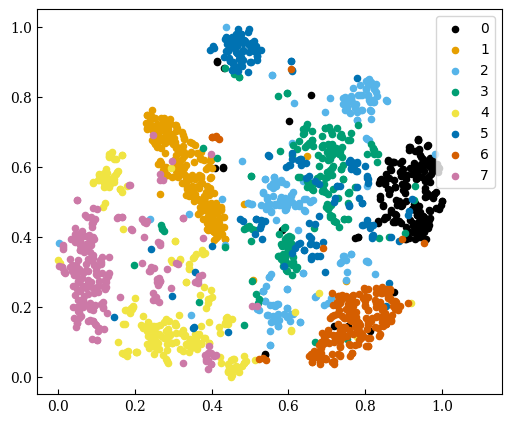

In [4]:
# Create the figure
# fig = plt.figure(figsize=(6, 5), dpi=350)
fig = plt.figure(figsize=(6, 5))

# The IDs are incremental for the labels
# target_ids = range(len(names))
target_ids = range(10)

# Okabe ito colors in hex
colors = [
    "#000000",       # black
    "#E69F00",       # orange
    "#56B4E9",       # sky blue
    "#009E73",       # bluish green
    "#F0E442",       # yellow
    "#0072B2",       # blue
    "#D55E00",       # vermillion
    "#CC79A7",       # reddish purple
]

# Reset plotting settings
plt.rcParams.update(mpl.rcParamsDefault)
# Set the new plot settings and update the plot's rcParams
params = {
    # "text.usetex": True,
    # "font.family "
    "font.family": "serif",
#     "font.serif": ["Computer Modern Serif"],
}
plt.rcParams.update(params)
ax = plt.gca()
ax.tick_params(direction='in')

# Set the style of the plot
# plt.style.use('fast')
plt.style.use('default')
# plt.grid(zorder=0)
# Scatter each class individually
# for i, c, label in zip(target_ids, colors, names):
for i, c in zip(target_ids, colors):
    plt.scatter(
        X[Y==i, 0],
        X[Y==i, 1],
        color=c,
        # label=pretty_names[label],
        label=i,
        s=20,
        zorder=3,
    )

# Scaling and formatting
plt.legend(
    loc='upper right',
    # shadow=True,
)
left, right = plt.xlim()
l_scale = 1.1
r_scale = 1.1
plt.xlim(l_scale*left, r_scale*right)

plt.show()

Next, set the destination filename, etc.

In [2]:
# Name of this experiment
experiment_top = "11_comparison"
# Name of the plot file itself
filename = "tsne.png"

# Point to the top of the project relative to this script
def projectdir(*args):
    return Path.cwd().joinpath("..", "..", "..", *args).resolve()
    # return Path.cwd().joinpath("..", "..", "..").resolve().joinpath(*args)

# Point to 
def paperplotdir(*args):
    return Path("C:\\", "Users", "Sasha", "Dropbox", "Apps", "Overleaf", "Paper-MST-TDY-C3-V3-Resubmission", "images", "results", experiment_top, *args)

def localplotdir(*args):
    return projectdir("work", "results", experiment_top, *args)

# Make the destination directories if they don't exist
paperplotdir().mkdir(parents=True, exist_ok=True)
localplotdir().mkdir(parents=True, exist_ok=True)

# Full location of of the local plot
savefile_local = localplotdir(filename)
# Full location of the paper directory, likely to vary between machines
savefile_paper = paperplotdir(filename)

## 2. Collect Features

Next, we load up all of the features from the `.csv` files in the "unpacked" data directory.

In [3]:
# Declare the names of all of the contexts that we are using
names = [
    "dot_dusk",
    "dot_morning",
    "emahigh_dusk",
    "emahigh_morning",
    # "emalow_dusk",
    # "emalow_morning",
    "pr_dusk",
    "pr_morning",
]

# Create a dictionary mapping the directory names to those used for plotting
pretty_names = {
    "dot_dusk": "DOTD",
    "dot_morning": "DOTM",
    "emahigh_dusk": "EMAD",
    "emahigh_morning": "EMAM",
    # "emalow_dusk": "EMAD",
    # "emalow_morning": "EMAM",
    "pr_dusk": "PRD",
    "pr_morning": "PRM",
}

# Define a quick feature data loading function
def collect_features(names):
    # Point to the top project directory
    # projectdir = Path.cwd().joinpath("..", "..", "..").resolve()
    # Point to the top-level directory of the activation features
    # datadir = projectdir.joinpath("data", "unpacked", "activations_yolov3_cell=1")
    datadir = projectdir("data", "unpacked", "activations_yolov3_cell=1")
    # Create a dictionary that links a name to a label integer index
    ntoi = {s:i for i,s in enumerate(names)}
    # Initialize an empty list for the labels and empty dataframe for the features
    labels = []
    df = pd.DataFrame()
    # Iterate over every l2 block
    for block in datadir.iterdir():
        # Iterate over ever context within that block
        for context in block.iterdir():
            # Check if we are wanting to use this context
            if context.name in names:
                # Point to the local .csv file containing the features
                local_file = context.joinpath("1", "average_features.csv")
                # Load and transpose the features (most Python functions are row-major, Julia is column-major)
                local_df = pd.read_csv(local_file, header=None).transpose()
                # Get the number of samples and prescribe them all the same integer label
                n_samples = len(local_df)
                labels.extend([ntoi[context.name]]*n_samples)
                # Add the local dataframe to the big one
                df = pd.concat((df, local_df))

    # Return the dataframe of features and list of labels
    return df, labels

# Collect the features into one big dataset with corresponding labels
df, labels = collect_features(names)
print(len(labels), len(df))

3873 3873


## 3. Compute the TSNE Transformation

We will now create TSNE object using scikit-learn and fit it to the data using two components for 2-D visualization.

In [4]:
# Create a tsne object targeting two dimensions for visualization
tsne = TSNE(n_components=2, random_state=0)
# Fit the data using TSNE
X = tsne.fit_transform(df)
# Normalize the transformed features
X = MinMaxScaler().fit_transform(X)
# Cast the labels into an np array
Y = np.array(labels)

## 4. Plot

Now we can plot the results to visualize how the TSNE casts the feature space to two dimensions.

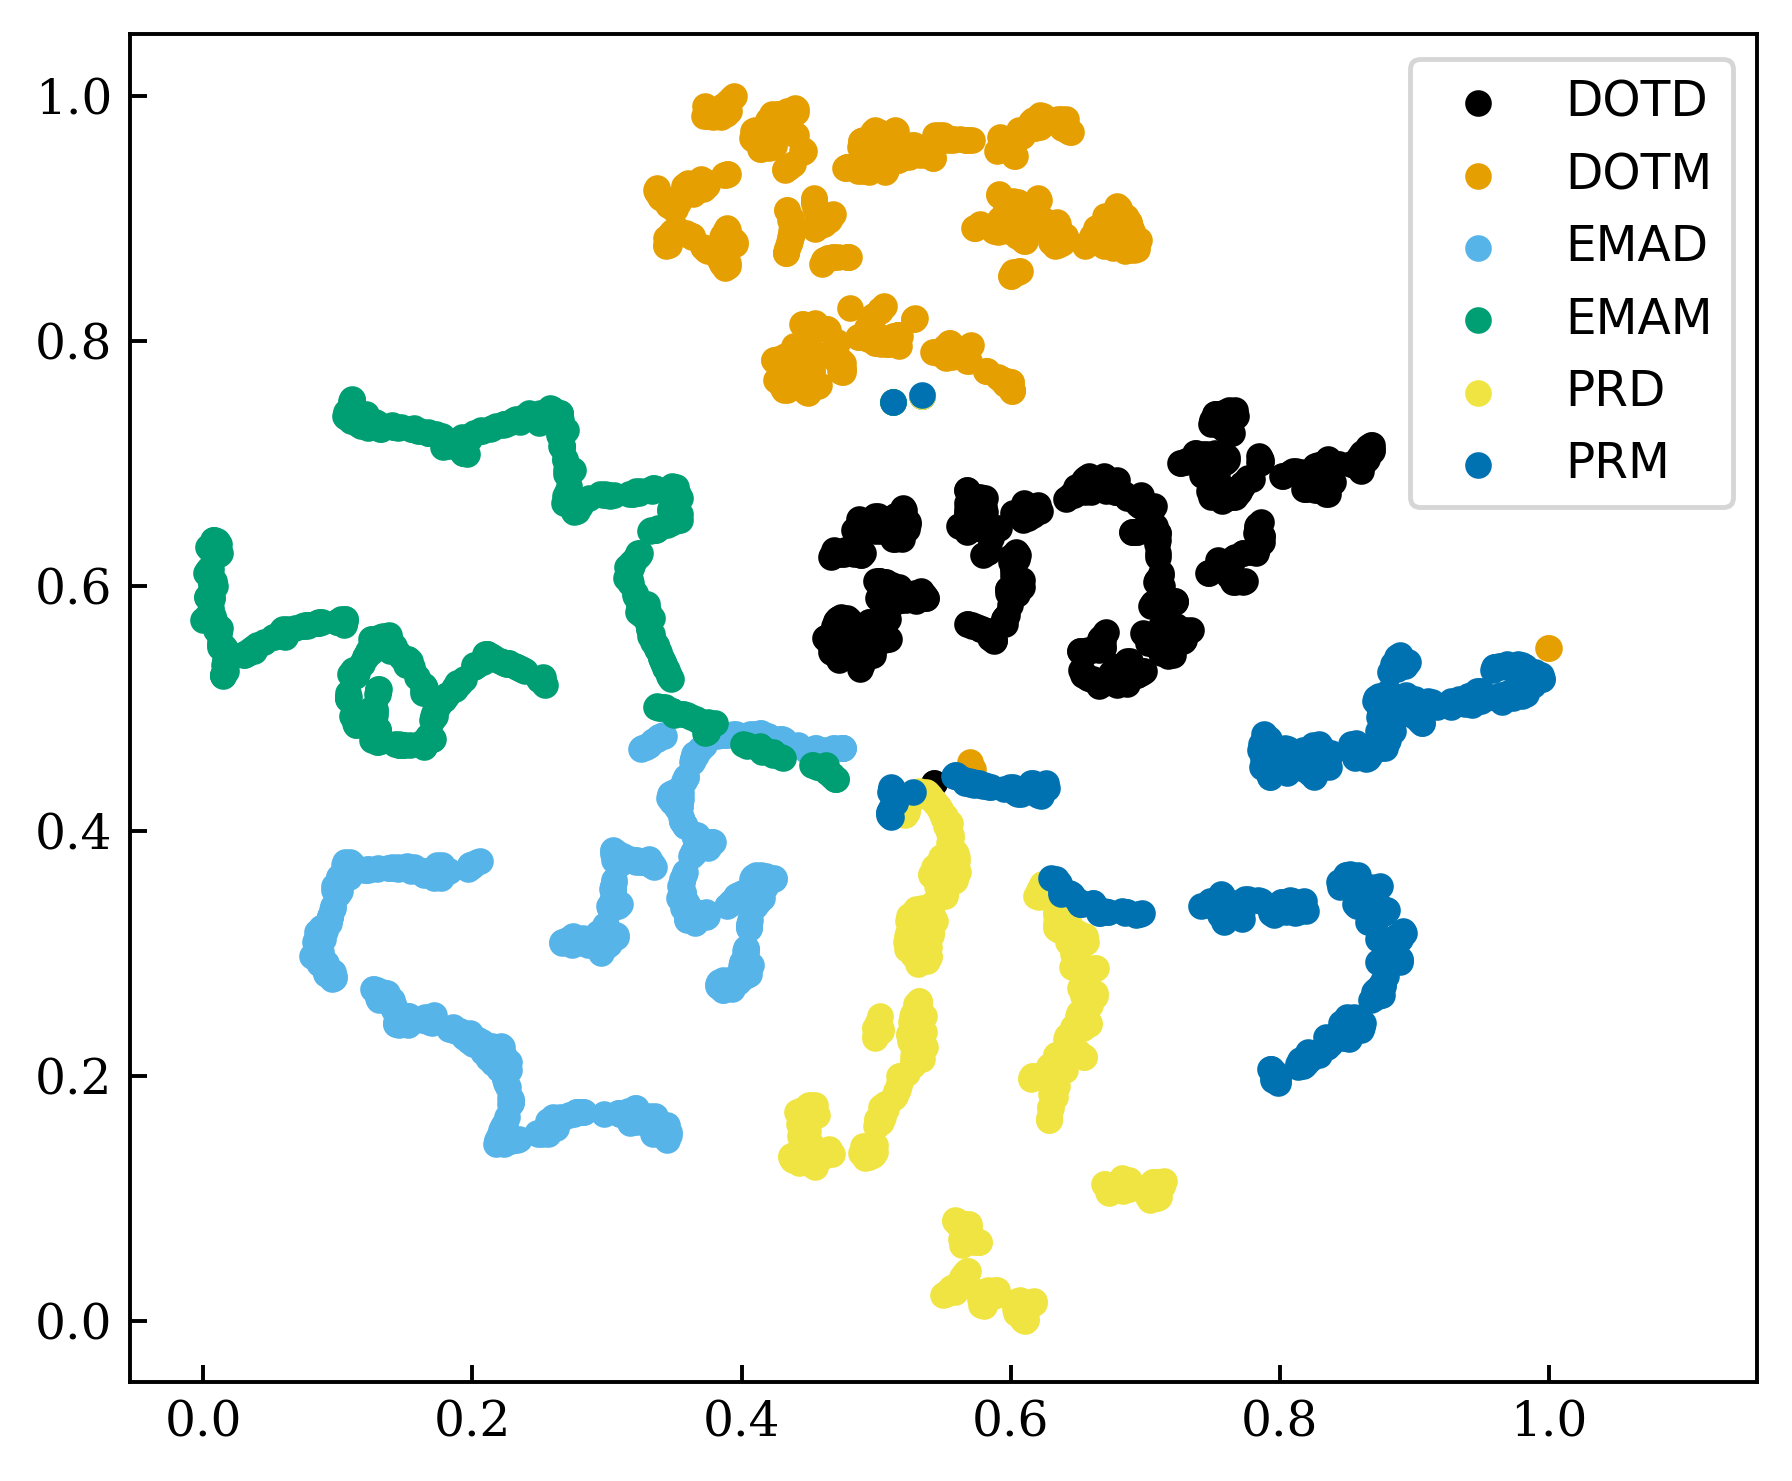

In [5]:
# Create the figure
fig = plt.figure(figsize=(6, 5), dpi=350)

# The IDs are incremental for the labels
target_ids = range(len(names))

# Okabe ito colors in hex
colors = [
    "#000000",       # black
    "#E69F00",       # orange
    "#56B4E9",       # sky blue
    "#009E73",       # bluish green
    "#F0E442",       # yellow
    "#0072B2",       # blue
    "#D55E00",       # vermillion
    "#CC79A7",       # reddish purple
]

# Reset plotting settings
plt.rcParams.update(mpl.rcParamsDefault)
# Set the new plot settings and update the plot's rcParams
params = {
    # "text.usetex": True,
    # "font.family "
    "font.family": "serif",
#     "font.serif": ["Computer Modern Serif"],
}
plt.rcParams.update(params)
ax = plt.gca()
ax.tick_params(direction='in')

# Set the style of the plot
# plt.style.use('fast')
plt.style.use('default')
# plt.grid(zorder=0)
# Scatter each class individually
for i, c, label in zip(target_ids, colors, names):
    plt.scatter(
        X[Y==i, 0],
        X[Y==i, 1],
        color=c,
        label=pretty_names[label],
        s=20,
        zorder=3,
    )

# Scaling and formatting
plt.legend(
    loc='upper right',
    # shadow=True,
)
left, right = plt.xlim()
l_scale = 1.1
r_scale = 1.1
plt.xlim(l_scale*left, r_scale*right)

plt.show()

## 5. Save

Finally, we will save the figure to the correct directory based upon the options set at the beginning of the notebook.

In [6]:
# Save the plot to both the local directory and the paper directory
fig.tight_layout()
fig.savefig(savefile_local, bbox_inches='tight')
fig.savefig(savefile_paper, bbox_inches='tight')